# Library Imports

In [3]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Model Selection and Tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, StandardScaler

# Regression Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Model Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load Datasets

In [5]:
df_liked = pd.read_csv("data/liked.csv")
df_fav_albums = pd.read_csv("data/liked_albums.csv")
df_not_liked = pd.read_csv("data/did_not_like.csv")
df_nmf = pd.read_csv("data/nmf.csv")

### Find the Similar artists to the df_liked and df_fav_albums artists

> Moved to a seperate notebook.

In [ ]:
# Load similar artist recommendations
df_fav_adjacent = pd.read_csv('data/artist_recommendations.csv')

# Check the first few rows
df_fav_adjacent.head()

In [7]:
df_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,21dfq9YrLKrCJA4I5OduxJ,Broadcast,Michigander,Michigander,2025-02-07,210348,1,NaN,2025-02-09T02:12:28Z,NaN,...,9,-9.951,1,0.0298,0.91600,0.346000,0.0909,0.5730,116.002,4
1,5FiITXz0a7G5yhEonDZjnE,Stay Home,11:11,Biig Piig,2025-02-07,164000,5,NaN,2025-02-07T15:49:04Z,NaN,...,0,-7.713,1,0.0273,0.38300,0.000036,0.7100,0.5920,154.054,4
2,3d34BjXrlp7rOPdGosajUB,Warplane,Glutton For Punishment,Heartworms,2025-02-07,331673,2,NaN,2025-02-07T13:17:04Z,post-punk,...,9,-12.469,0,0.0558,0.00344,0.625000,0.0915,0.0681,139.998,4
3,27a1HBHlfXd1o1yEzJd8iy,Mad Catch,Glutton For Punishment,Heartworms,2025-02-07,190576,4,NaN,2025-02-07T13:08:50Z,post-punk,...,0,-9.766,1,0.0765,0.01570,0.000789,0.1360,0.7440,123.086,4
4,2262bWmqomIaJXwCRHr13j,Sailor Song,Sailor Song,Gigi Perez,2024-07-26,211978,93,NaN,2025-02-04T01:45:03Z,NaN,...,11,-10.432,1,0.0254,0.68200,0.000067,0.1930,0.2730,94.938,4


## Collect Similar Artists to the New Music Friday Dataset

> Moved to a seperate notebook.

In [83]:
import urllib.parse
artist_name = "Kina Grannis, Imaginary Future"
encoded_artist = urllib.parse.quote(artist_name)


In [8]:
df_fav_albums.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,0UOeq7bSskoJa4cJaJOmFS,Ticking,Letter to Self,SPRINTS,2024-01-05,186949,31,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-6.490,1.0,0.3440,0.02500,0.076500,0.0934,0.291,175.574,4.0
1,02bA26OEe0nNFyE3YcNx4K,Heavy,Letter to Self,SPRINTS,2024-01-05,207409,46,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-5.925,1.0,0.0591,0.00435,0.000738,0.0877,0.189,88.581,4.0
2,7IPDhCIQlpvxVxtC1Q7Jq4,Cathedral,Letter to Self,SPRINTS,2024-01-05,179694,30,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,7.0,-6.231,1.0,0.0473,0.00978,0.002700,0.0887,0.397,119.056,4.0
3,65fPteG9ctHt2rrJxlbMr8,Shaking Their Hands,Letter to Self,SPRINTS,2024-01-05,222489,28,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-5.658,0.0,0.0533,0.19900,0.108000,0.1330,0.551,89.485,4.0
4,4UgkFdXpJD0fhw06BMk0bz,Adore Adore Adore,Letter to Self,SPRINTS,2024-01-05,157766,36,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-4.401,0.0,0.2570,0.01070,0.000107,0.1010,0.402,176.054,4.0


In [9]:
df_not_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,54KEm0VI9i3ic7VHHKHKRx,¿Cómo Así?,ORQUÍDEAS,Kali Uchis,2024-01-12,169654,57,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,6.0,-7.662,0.0,0.0892,0.04170,0.346000,0.154,0.379,135.985,4.0
1,5mVkTPlTPxlQOn7kEvuM3j,Me Pongo Loca,ORQUÍDEAS,Kali Uchis,2024-01-12,177815,54,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,7.0,-8.680,0.0,0.0426,0.03710,0.152000,0.106,0.407,114.999,4.0
2,6XaJfhwof7qIgbbXO5tIQI,Igual Que Un Ángel (with Peso Pluma),ORQUÍDEAS,"Kali Uchis,Peso Pluma",2024-01-12,260370,76,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,"corrido,corridos tumbados,corridos bélicos,mús...",...,5.0,-5.340,0.0,0.0320,0.00449,0.000663,0.185,0.482,108.001,4.0
3,52x8HIGuk1gGTlvO8CuLNS,Pensamientos Intrusivos,ORQUÍDEAS,Kali Uchis,2024-01-12,192027,60,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,9.0,-8.333,0.0,0.0394,0.57500,0.012900,0.110,0.511,119.994,4.0
4,3RleMgz4iO0BNezGdSxDnY,Diosa,ORQUÍDEAS,Kali Uchis,2024-01-12,156037,59,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,5.0,-5.518,0.0,0.0668,0.06750,0.000101,0.078,0.698,107.994,4.0


In [10]:
df_nmf.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,56D5iLqv8WVcQTvyL0N0ay,Live Forever,Sharon Van Etten & The Attachment Theory,Sharon Van Etten,2025-02-07,339867,15,mmr4r23xnc6oh1c77lysfbqg4,2025-02-07T11:39:45Z,NaN,...,0,-7.448,0,0.0367,0.21700,0.128000,0.107,0.124,147.096,4
1,1DO4aHyMKVW66VWnA4pNeV,Afterlife,Sharon Van Etten & The Attachment Theory,Sharon Van Etten,2025-02-07,248215,13,mmr4r23xnc6oh1c77lysfbqg4,2025-02-07T11:39:45Z,NaN,...,2,-7.523,1,0.0284,0.33000,0.012800,0.110,0.205,97.981,4
2,33Wi8Etr6ljOsBViBOKWQ5,Idiot Box,Sharon Van Etten & The Attachment Theory,Sharon Van Etten,2025-02-07,250409,22,mmr4r23xnc6oh1c77lysfbqg4,2025-02-07T11:39:45Z,NaN,...,7,-5.178,1,0.0366,0.27800,0.000358,0.108,0.612,144.828,4
3,56nsBD9bmnuW7V5wHlyVCx,Trouble,Sharon Van Etten & The Attachment Theory,Sharon Van Etten,2025-02-07,300045,12,mmr4r23xnc6oh1c77lysfbqg4,2025-02-07T11:39:45Z,NaN,...,11,-9.927,1,0.0340,0.48800,0.175000,0.129,0.346,110.081,4
4,1aUzvglR5E3Jgi0DdyD7nF,Indio,Sharon Van Etten & The Attachment Theory,Sharon Van Etten,2025-02-07,167383,11,mmr4r23xnc6oh1c77lysfbqg4,2025-02-07T11:39:45Z,NaN,...,1,-5.415,1,0.0302,0.00835,0.000036,0.290,0.720,88.029,4


> A quick reminder of the standard columns of a spotify export.

In [12]:
df_liked.columns

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At',
       'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature'],
      dtype='object')

### Add Target Labels for Training Feature

In [14]:
# Assign liked scores before combining
df_liked['liked'] = 100
df_fav_albums['liked'] = 65
df_not_liked['liked'] = 30
df_nmf['liked'] = 0

# Add playlist_origin column before combining
df_liked['playlist_origin'] = 'df_liked'
df_fav_albums['playlist_origin'] = 'df_fav_albums'
df_not_liked['playlist_origin'] = 'df_not_liked'
df_nmf['playlist_origin'] = 'df_nmf'

### Check application of the target encoding

In [16]:
df_liked['liked'].head()

0    100
1    100
2    100
3    100
4    100
Name: liked, dtype: int64

In [17]:
df_fav_albums['liked'].head()

0    65
1    65
2    65
3    65
4    65
Name: liked, dtype: int64

In [18]:
df_not_liked['liked'].head()

0    30
1    30
2    30
3    30
4    30
Name: liked, dtype: int64

In [19]:
df_nmf['liked'].head()

0    0
1    0
2    0
3    0
4    0
Name: liked, dtype: int64

## Merge The Datasets

In [21]:
df = pd.concat([df_liked, df_fav_albums, df_not_liked, df_nmf], ignore_index=True)

In [22]:
metadata_columns = ['Track Name', 'Album Name', 'Artist Name(s)']
metadata_df = df[metadata_columns].copy()

In [23]:
# Remove duplicates: Keep the highest 'liked' score (100 > 65)
df = df.sort_values(by='liked', ascending=False)  # Ensures 100-rated songs come first
df = df.drop_duplicates(subset=['Track Name', 'Artist Name(s)'], keep='first')

In [24]:
# Count how many songs by each artist are liked (liked >= 45) and track playlist_origin
artist_song_count = df[df['liked'] >= 45].groupby('Artist Name(s)')['liked'].count()

# Add a column for the count of liked songs per artist
df['artist_song_count'] = df['Artist Name(s)'].apply(lambda x: artist_song_count.get(x, 0))

# Create a 'favorite_artist' column: 1 if they have at least one liked song, else 0
df['favorite_artist'] = df['artist_song_count'].apply(lambda x: 1 if x > 0 else 0)

# Now, drop or keep the `artist_song_count` column based on what you need for modeling
df.drop(columns=['artist_song_count'], inplace=True)


In [25]:
df.columns #Checking to remind myself what is all available to drop, keep seperate as metadata, etc.

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At',
       'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature', 'liked', 'playlist_origin',
       'favorite_artist'],
      dtype='object')

#### Drop columns that won't help the model (Track ID, Added By, Added At, Time Signature)

In [27]:
df.drop(columns=['Track ID', 'Added By', 'Added At', 'Time Signature'], inplace=True)

#### Handle missing values (if any)

In [29]:
 df.isna().sum()

Track Name             0
Album Name             0
Artist Name(s)         0
Release Date           0
Duration (ms)          0
Popularity             0
Genres              5443
Record Label           3
Danceability           8
Energy                 8
Key                    8
Loudness               8
Mode                   8
Speechiness            8
Acousticness           8
Instrumentalness       8
Liveness               8
Valence                8
Tempo                  8
liked                  0
playlist_origin        0
favorite_artist        0
dtype: int64

In [30]:
# Fill missing genres with "Unknown"
df['Genres'] = df['Genres'].fillna("Unknown")

In [31]:
# Check if the same rows have missing values across these columns
df[df[['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].isna().any(axis=1)]

,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Genres,Record Label,Danceability,Energy,...,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,liked,playlist_origin,favorite_artist
9655,Scene 5: Never Was Lost,Welcome 2 Collegrove,"2 Chainz,Lil Wayne",2023-11-17,14421,0,"rap,southern hip hop,hip hop",2Chainz PS/Def Jam,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,df_fav_albums,1
9436,libra intuition,Water Made Us,Jamila Woods,2023-10-13,14867,0,alternative r&b,Jagjaguwar,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,df_fav_albums,1
11540,A:B,Hope's Convenience,Ivy Wye,2022-04-15,59077,0,Unknown,Ivy Wye,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,df_fav_albums,1
11456,And in the Darkness,"And In The Darkness, Hearts Aglow",Weyes Blood,2022-11-18,14893,1,"art pop,baroque pop,chamber pop",Sub Pop Records,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,df_fav_albums,1
10177,Four Chords Pt. III: Diminishing Returns,THE UNRAVELING OF PUPTHEBAND,PUP,2022-04-01,9280,0,"midwest emo,emo,punk",Rise Records,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,df_fav_albums,1
6463,Music??,"My Light, My Destroyer",Cassandra Jenkins,2024-07-12,10841,3,Unknown,Dead Oceans,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,df_fav_albums,1
12101,(soft air),Night Palace,Mount Eerie,2024-11-01,62213,32,"slowcore,indie folk",P.W. Elverum & Sun,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,df_not_liked,0
12049,Meaning of Regret,Sky Hundred,Parannoul,2024-08-07,72946,19,"shoegaze,dream pop,noise rock,slowcore,math rock",Parannoul,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,df_not_liked,0


In [32]:
# Drop low-quality rows (missing audio features)
df.dropna(subset=['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 
                  'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo'], inplace=True)


## Save the favorite labels

In [34]:
top_labels = pd.concat([df_liked['Record Label'], df_fav_albums['Record Label']]).value_counts().head(20).index
top_labels

Index(['Dead Oceans', 'Columbia', 'Polyvinyl Records', 'Anti/Epitaph',
       'Loma Vista Recordings', 'Jagjaguwar', 'Mom+Pop', 'Atlantic Records',
       'Sub Pop Records', '4AD', 'Warner Records', 'Secretly Canadian',
       'Carpark Records', 'BMG Rights Management (US) LLC', 'ATO Records',
       'Domino Recording Co', 'Nettwerk Music Group', 'New West Records',
       'Double Double Whammy', 'Saddle Creek'],
      dtype='object', name='Record Label')

In [35]:
# Step 1: Identify the top 20 labels from both df_liked and df_fav_albums
top_labels = pd.concat([df_liked['Record Label'], df_fav_albums['Record Label']]).value_counts().head(20).index

# Step 2: One-hot encode the 'Record Label' column for the top 20 labels
for label in top_labels:
    df[label] = df['Record Label'].apply(lambda x: 1 if label in str(x) else 0)

# Step 3: Drop the original 'Record Label' column
df.drop(columns=['Record Label'], inplace=True)


#### Rechecking for Nulls

In [37]:
 df.isna().sum()

Track Name                        0
Album Name                        0
Artist Name(s)                    0
Release Date                      0
Duration (ms)                     0
Popularity                        0
Genres                            0
Danceability                      0
Energy                            0
Key                               0
Loudness                          0
Mode                              0
Speechiness                       0
Acousticness                      0
Instrumentalness                  0
Liveness                          0
Valence                           0
Tempo                             0
liked                             0
playlist_origin                   0
favorite_artist                   0
Dead Oceans                       0
Columbia                          0
Polyvinyl Records                 0
Anti/Epitaph                      0
Loma Vista Recordings             0
Jagjaguwar                        0
Mom+Pop                     

In [38]:
df.columns

Index(['Track Name', 'Album Name', 'Artist Name(s)', 'Release Date',
       'Duration (ms)', 'Popularity', 'Genres', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'liked',
       'playlist_origin', 'favorite_artist', 'Dead Oceans', 'Columbia',
       'Polyvinyl Records', 'Anti/Epitaph', 'Loma Vista Recordings',
       'Jagjaguwar', 'Mom+Pop', 'Atlantic Records', 'Sub Pop Records', '4AD',
       'Warner Records', 'Secretly Canadian', 'Carpark Records',
       'BMG Rights Management (US) LLC', 'ATO Records', 'Domino Recording Co',
       'Nettwerk Music Group', 'New West Records', 'Double Double Whammy',
       'Saddle Creek'],
      dtype='object')

### Genre's there are a LOT of them...

In [40]:
# Combine genres from both 'df_liked' and 'df_fav_albums' DataFrames
combined_genres = pd.concat([df_liked['Genres'], df_fav_albums['Genres']])

# Split, stack, and count the genres across both DataFrames
top_genres = combined_genres.str.split(',', expand=True).stack().value_counts().head(30).index

# Ensure "Unknown" is not processed as a valid genre
df[['Genres_1', 'Genres_2', 'Genres_3']] = df['Genres'].str.split(',', expand=True, n=2)

# Replace "Unknown" with NaN
df[['Genres_1', 'Genres_2', 'Genres_3']] = df[['Genres_1', 'Genres_2', 'Genres_3']].replace('Unknown', pd.NA)

# Create a function to check if a genre is in top_genres, ensuring we handle NAType
def genre_bump(genre_column):
    if pd.isna(genre_column):  # Explicitly check for NAType
        return False
    return genre_column in top_genres  # This will work since it's a string comparison

# Apply the bump function to each of the genre columns
df['Bump_Genre_1'] = df['Genres_1'].apply(genre_bump)
df['Bump_Genre_2'] = df['Genres_2'].apply(genre_bump)
df['Bump_Genre_3'] = df['Genres_3'].apply(genre_bump)

# Count the number of bumps (genres that match the top genres)
df['Genre_Bump_Count'] = df[['Bump_Genre_1', 'Bump_Genre_2', 'Bump_Genre_3']].sum(axis=1)

# If any of the bumps are True (i.e., genre matches and not "Unknown"), bump the song
df['Genre_Bump'] = (df['Genre_Bump_Count'] > 0).astype(int)

# Assign a score based on the number of genre matches (using 20-point multiplier)
df['Genre_Bump_Score'] = df['Genre_Bump_Count'] * 20  # Multiply by 20 for each match

# Show the top 20 rows with the adjusted score
df[['Track Name', 'Album Name', 'Artist Name(s)', 'Genres_1', 'Genres_2', 'Genres_3', 
    'Genre_Bump_Count', 'Genre_Bump_Score', 'liked']].head(20)

,Track Name,Album Name,Artist Name(s),Genres_1,Genres_2,Genres_3,Genre_Bump_Count,Genre_Bump_Score,liked
0,Broadcast,Michigander,Michigander,<NA>,None,None,0,0,100
3694,Tramp Like You,Hydranism,Oracle Sisters,<NA>,None,None,0,0,100
3702,Sepsis,Blondshell,Blondshell,<NA>,None,None,0,0,100
3701,Joiner,Blondshell,Blondshell,<NA>,None,None,0,0,100
3700,Dangerous,Blondshell,Blondshell,<NA>,None,None,0,0,100
3699,Devil Swim,Drop Cherries,Billie Marten,<NA>,None,None,0,0,100
3698,Tongue,Drop Cherries,Billie Marten,<NA>,None,None,0,0,100
3697,This Is Paradise (But Not For Us),Strange Strangers,Devon Church,gothic country,None,None,0,0,100
3696,Time To Pretend,Time To Pretend,Charlie Hickey,<NA>,None,None,0,0,100
3695,New Suede Shoes,Winner,Overcoats,<NA>,None,None,0,0,100


### Curious what the top genres were?

In [42]:
top_genres

Index(['chamber pop', 'indie folk', 'americana', 'alt country',
       'alternative r&b', 'indie', 'midwest emo', 'jangle pop', 'indie rock',
       'bedroom pop', 'power pop', 'art pop', 'post-punk', 'folk', 'dream pop',
       'folk pop', 'hip hop', 'baroque pop', 'east coast hip hop', 'rap',
       'jazz rap', 'southern hip hop', 'folk punk', 'neo soul', 'bluegrass',
       'retro soul', 'emo', 'shoegaze', 'afropop', 'indie pop'],
      dtype='object')

In [43]:
df.columns

Index(['Track Name', 'Album Name', 'Artist Name(s)', 'Release Date',
       'Duration (ms)', 'Popularity', 'Genres', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'liked',
       'playlist_origin', 'favorite_artist', 'Dead Oceans', 'Columbia',
       'Polyvinyl Records', 'Anti/Epitaph', 'Loma Vista Recordings',
       'Jagjaguwar', 'Mom+Pop', 'Atlantic Records', 'Sub Pop Records', '4AD',
       'Warner Records', 'Secretly Canadian', 'Carpark Records',
       'BMG Rights Management (US) LLC', 'ATO Records', 'Domino Recording Co',
       'Nettwerk Music Group', 'New West Records', 'Double Double Whammy',
       'Saddle Creek', 'Genres_1', 'Genres_2', 'Genres_3', 'Bump_Genre_1',
       'Bump_Genre_2', 'Bump_Genre_3', 'Genre_Bump_Count', 'Genre_Bump',
       'Genre_Bump_Score'],
      dtype='object')

## Standardize the numeric columns

In [45]:
# Define numeric columns explicitly (excluding 'artist_song_count')
numeric_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 
                'Speechiness', 'Acousticness', 'Instrumentalness', 
                'Liveness', 'Valence', 'Tempo']

# Ensure numeric columns exist in the dataframe before applying transformations
numeric_cols = [col for col in numeric_cols if col in df.columns]

# Ensure numeric columns don't contain NaNs before scaling
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(0)  # Replace any remaining NaNs with 0

# Standardize numerical features
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [46]:
#Viewing the numeric columns after standardization
df[numeric_cols]

,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,0.850660,-0.596189,1.066578,-0.360050,0.597283,-0.482433,1.668818,1.001449,-0.654309,0.590127,-0.144101
3694,0.338271,-1.599674,-0.328618,-1.489650,0.597283,-0.386821,1.609032,1.908103,-0.940217,-1.558026,0.664942
3702,0.144563,0.558684,0.508500,0.863033,0.597283,-0.487629,-1.055963,-0.450860,0.765249,-0.091279,0.529450
3701,0.344520,0.684120,1.066578,0.627443,0.597283,-0.429431,-1.067439,-0.124732,-0.496739,-1.035759,0.192388
3700,-1.236388,-1.469913,1.066578,-1.127265,0.597283,-0.455412,-0.121775,-0.431652,-0.482479,-0.867563,2.143727
...,...,...,...,...,...,...,...,...,...,...,...
12664,-0.049145,-0.535634,-1.444775,-0.388525,0.597283,-0.420077,0.780995,-0.450876,0.095041,-1.014195,0.494507
12663,-0.067891,0.069918,-0.886697,-0.115326,0.597283,0.538125,1.420706,-0.450276,-0.510999,-0.682118,-1.254386
12662,1.138098,0.134798,1.066578,0.627174,0.597283,-0.118690,-0.381845,-0.450876,1.471107,0.935143,0.662347
12661,-1.123912,-0.682696,-1.444775,0.331141,0.597283,-0.430470,0.766048,-0.450864,-0.375531,-1.311771,0.762222


### Seperate New Music Friday and Save it for Later!

# Data Dictionary with dtypes

| **Column Name**                    | **Description**                                                                                       | **dtype**    |
|-------------------------------------|-------------------------------------------------------------------------------------------------------|--------------|
| **Track Name**                      | The name of the track/song.                                                                          | object       |
| **Album Name**                      | The name of the album the track is part of.                                                          | object       |
| **Artist Name(s)**                  | The name(s) of the artist(s) performing the track.                                                   | object       |
| **Release Date**                    | The date the album or track was released.                                                            | object       |
| **Duration (ms)**                   | The duration of the track in milliseconds.                                                           | int64        |
| **Popularity**                      | A numerical value representing the track's popularity, typically based on streaming data.            | int64        |
| **Genres**                          | The primary genres associated with the track, usually a comma-separated list.                        | object       |
| **Danceability**                    | A value representing how suitable the track is for dancing, typically from 0 to 1.                    | float64      |
| **Energy**                          | A value representing the energy level of the track, typically from 0 to 1.                           | float64      |
| **Key**                             | The musical key of the track (C, D, etc.).                                                           | float64      |
| **Loudness**                        | The average loudness of the track in decibels (dB).                                                  | float64      |
| **Mode**                            | The mode of the track (Major/Minor).                                                                  | float64      |
| **Speechiness**                     | A value indicating the presence of spoken words in the track.                                        | float64      |
| **Acousticness**                    | A value indicating the amount of acoustic sound in the track.                                        | float64      |
| **Instrumentalness**                | A value indicating the likelihood that the track is instrumental.                                    | float64      |
| **Liveness**                        | A value representing the track's live performance aspect.                                            | float64      |
| **Valence**                         | A value indicating the track's musical positiveness or mood.                                         | float64      |
| **Tempo**                           | The tempo of the track in beats per minute (BPM).                                                    | float64      |
| **playlist_origin**                 | The source playlist of the track (e.g., 'df_liked', 'df_fav_albums', 'df_not_liked', 'df_nmf').       | object       |
| **liked**                           | The target variable indicating how much the user liked the track, ranging from 0 to 100.             | int64        |
| **Dead Oceans**                     | Binary indicator of whether the track is associated with the Dead Oceans label.                     | int64        |
| **Columbia**                        | Binary indicator of whether the track is associated with the Columbia label.                         | int64        |
| **Polyvinyl Records**               | Binary indicator of whether the track is associated with the Polyvinyl Records label.                | int64        |
| **Anti/Epitaph**                    | Binary indicator of whether the track is associated with the Anti/Epitaph label.                     | int64        |
| **Loma Vista Recordings**           | Binary indicator of whether the track is associated with the Loma Vista Recordings label.            | int64        |
| **Jagjaguwar**                      | Binary indicator of whether the track is associated with the Jagjaguwar label.                      | int64        |
| **Mom+Pop**                         | Binary indicator of whether the track is associated with the Mom+Pop label.                          | int64        |
| **Atlantic Records**                | Binary indicator of whether the track is associated with the Atlantic Records label.                 | int64        |
| **Sub Pop Records**                 | Binary indicator of whether the track is associated with the Sub Pop Records label.                  | int64        |
| **Warner Records**                  | Binary indicator of whether the track is associated with the Warner Records label.                   | int64        |
| **4AD**                             | Binary indicator of whether the track is associated with the 4AD label.                              | int64        |
| **Domino Recording Co**             | Binary indicator of whether the track is associated with the Domino Recording Co label.              | int64        |
| **Secretly Canadian**               | Binary indicator of whether the track is associated with the Secretly Canadian label.                | int64        |
| **Carpark Records**                 | Binary indicator of whether the track is associated with the Carpark Records label.                  | int64        |
| **BMG Rights Management (US) LLC**  | Binary indicator of whether the track is associated with the BMG Rights Management label.            | int64        |
| **ATO Records**                     | Binary indicator of whether the track is associated with the ATO Records label.                      | int64        |
| **Nettwerk Music Group**            | Binary indicator of whether the track is associated with the Nettwerk Music Group label.             | int64        |
| **New West Records**                | Binary indicator of whether the track is associated with the New West Records label.                 | int64        |
| **Double Double Whammy**            | Binary indicator of whether the track is associated with the Double Double Whammy label.             | int64        |
| **Saddle Creek**                    | Binary indicator of whether the track is associated with the Saddle Creek label.                     | int64        |
| **Genres_1**                        | A sub-genre or another classification of the track, typically the first in a set.                     | object       |
| **Genres_2**                        | A second sub-genre or classification of the track.                                                    | object       |
| **Genres_3**                        | A third sub-genre or classification of the track.                                                     | object       |
| **Bump_Genre_1**                    | A genre from the bumped (adjusted) genres list, typically the first genre.                           | bool         |
| **Bump_Genre_2**                    | A second genre from the bumped (adjusted) genres list.                                                | bool         |
| **Bump_Genre_3**                    | A third genre from the bumped (adjusted) genres list.                                                 | bool         |
| **Genre_Bump_Count**                | A count of how many times the genre has been bumped (adjusted) based on user input or algorithm.      | int64        |
| **Genre_Bump**                      | A cumulative score or adjustment for the genre based on user feedback or algorithmic bumping.         | int32        |
| **Genre_Bump_Score**                | A final score for the genre after all adjustments, typically used for recommendations or predictions.  | int64        |


## Clean UP the Columns to use and Not Use for the Machine Learning

In [50]:
# Drop unnecessary columns
df_cleaned = df.drop(columns=['Track Name', 'Album Name', 'Artist Name(s)', 
                              'Genres', 'Genres_1', 'Genres_2', 'Genres_3', 
                              'Bump_Genre_1', 'Bump_Genre_2', 'Bump_Genre_3',
                              'Genre_Bump_Count', 'Genre_Bump', 'Genre_Bump_Score',
                              'liked', 'Release Date', 'playlist_origin',
                              'Duration (ms)'])

# Prepare the feature matrix and target variable
X = df_cleaned
y = df['liked']  # target variable

# The data is now ready for regression modeling


In [51]:
# Separate the NMF data from the rest of the data
df_nmf_separated = df_cleaned[df['playlist_origin'] == 'df_nmf']
df_training_data = df_cleaned[df['playlist_origin'] != 'df_nmf']


## Linear Regression (Simple Model)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression
lr = LinearRegression()
lr.fit(X, y)

# Predictions
y_pred_lr = lr.predict(X)

# Metrics
mse_lr = mean_squared_error(y, y_pred_lr)
r2_lr = r2_score(y, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R2: {r2_lr}")


Linear Regression MSE: 368.3192272126864
Linear Regression R2: 0.4735002427819064


## Ridge Regression (REgularized Linear Regression)

In [55]:
from sklearn.linear_model import Ridge

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

# Predictions
y_pred_ridge = ridge.predict(X)

# Metrics
mse_ridge = mean_squared_error(y, y_pred_ridge)
r2_ridge = r2_score(y, y_pred_ridge)

print(f"Ridge Regression MSE: {mse_ridge}")
print(f"Ridge Regression R2: {r2_ridge}")


Ridge Regression MSE: 368.31988314237867
Ridge Regression R2: 0.47349930515281125


## Lasso Regression (L1 Regularization)

In [57]:
from sklearn.linear_model import Lasso

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

# Predictions
y_pred_lasso = lasso.predict(X)

# Metrics
mse_lasso = mean_squared_error(y, y_pred_lasso)
r2_lasso = r2_score(y, y_pred_lasso)

print(f"Lasso Regression MSE: {mse_lasso}")
print(f"Lasso Regression R2: {r2_lasso}")

Lasso Regression MSE: 371.7708432726851
Lasso Regression R2: 0.4685662754966471


## Random Forest Regressor (Ensemble Model)

In [59]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

# Predictions
y_pred_rf = rf.predict(X)

# Metrics
mse_rf = mean_squared_error(y, y_pred_rf)
r2_rf = r2_score(y, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R2: {r2_rf}")


Random Forest MSE: 47.8874127853034
Random Forest R2: 0.9315465787760633


## Gradient Boosting Regressor (Advanced Ensemble Method)

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X, y)

# Predictions
y_pred_gb = gb.predict(X)

# Metrics
mse_gb = mean_squared_error(y, y_pred_gb)
r2_gb = r2_score(y, y_pred_gb)

print(f"Gradient Boosting MSE: {mse_gb}")
print(f"Gradient Boosting R2: {r2_gb}")


Gradient Boosting MSE: 323.80981465459075
Gradient Boosting R2: 0.5371249280395816


## Get the Top 15 Features

In [63]:
# Get feature importances for Random Forest and Gradient Boosting
rf_feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
gb_feature_importances = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Top 15 features for Random Forest
print("Top 15 Random Forest Features:")
print(rf_feature_importances.head(15))

# Top 15 features for Gradient Boosting
print("Top 15 Gradient Boosting Features:")
print(gb_feature_importances.head(15))


Top 15 Random Forest Features:
favorite_artist     0.462672
Popularity          0.071741
Loudness            0.049029
Valence             0.048225
Acousticness        0.048115
Tempo               0.047380
Speechiness         0.047286
Danceability        0.046107
Liveness            0.045607
Energy              0.044546
Instrumentalness    0.040761
Key                 0.022965
Mode                0.004255
Jagjaguwar          0.002738
Atlantic Records    0.002571
dtype: float64
Top 15 Gradient Boosting Features:
favorite_artist     0.863653
Popularity          0.078305
Speechiness         0.006959
Loudness            0.006719
Instrumentalness    0.006073
Acousticness        0.005479
Liveness            0.005098
Valence             0.004814
Danceability        0.004341
Tempo               0.003547
Energy              0.003287
Anti/Epitaph        0.001953
Jagjaguwar          0.001824
Atlantic Records    0.001798
Dead Oceans         0.001492
dtype: float64


In [64]:
# Focus on the bump-related columns
bump_columns = ['Bump_Genre_1', 'Bump_Genre_2', 'Bump_Genre_3', 'Genre_Bump_Count', 'Genre_Bump', 'Genre_Bump_Score']

# Include 'liked' in the correlation check
df_bumps = df[bump_columns + ['liked']]

# Compute the correlation matrix for bump-related columns
bump_correlation = df_bumps.corr()

# Get the correlation values with 'liked'
liked_bump_correlation = bump_correlation['liked'].sort_values(ascending=False)

# Show the top correlated bump features with 'liked'
print(liked_bump_correlation)


liked               1.000000
Bump_Genre_1        0.005174
Genre_Bump         -0.017497
Bump_Genre_3       -0.023761
Genre_Bump_Score   -0.026968
Genre_Bump_Count   -0.026968
Bump_Genre_2       -0.054460
Name: liked, dtype: float64


## Testing against a completely different dataset of new music!

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Keep 'liked' only for the training data, ignore for NMF songs
df_cleaned = df.drop(columns=['Track Name', 'Album Name', 'Artist Name(s)', 
                              'Genres', 'Genres_1', 'Genres_2', 'Genres_3', 
                              'Bump_Genre_1', 'Bump_Genre_2', 'Bump_Genre_3',
                               'Genre_Bump', 'Genre_Bump_Score',
                              'Release Date', 'playlist_origin'])  # Exclude non-numeric columns

# Separate the NMF data from the rest of the data
df_nmf_separated = df[df['playlist_origin'] == 'df_nmf']
df_training_data = df[df['playlist_origin'] != 'df_nmf']

# Prepare the feature matrix and target variable for training (keep only numeric columns)
X_train = df_training_data.select_dtypes(include=['number']).drop(columns=['liked'])  # Remove 'liked' from training features
y_train = df_training_data['liked']  # 'liked' is the target for training

# Train the Random Forest model on the training data
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Prepare the feature matrix for prediction using NMF data (only numeric columns)
X_nmf = df_nmf_separated.select_dtypes(include=['number']).drop(columns=['liked'])  # No 'liked' column in the prediction set

# Predict the 'liked' scores for NMF data (without interfering with the 0s)
y_pred_nmf = rf.predict(X_nmf)

# Add the predicted scores to the NMF dataset
df_nmf_separated['Predicted_Liked_Score'] = y_pred_nmf

# Group by album name only and aggregate predicted scores
aggregated_album_scores = df_nmf_separated.groupby('Album Name').agg(
    AggregatePredictedAverage=('Predicted_Liked_Score', 'mean'),  # Take the mean of predicted scores
    Artists=('Artist Name(s)', 'first'),  # Get the first artist for the album (you could also choose a more robust method if needed)
    ReleaseDate=('Release Date', 'first')  # You could add other fun data like release date
).reset_index()

# Display the head of the aggregated results
print(aggregated_album_scores.head(20))

# Optionally, save the aggregated scores to a CSV
aggregated_album_scores.to_csv('recommended_albums.csv', index=False)

# If you want to evaluate the Random Forest model on the training data
y_pred_rf_train = rf.predict(X_train)
mse_rf = mean_squared_error(y_train, y_pred_rf_train)
r2_rf = r2_score(y_train, y_pred_rf_train)

print(f"Random Forest MSE (Training): {mse_rf}")
print(f"Random Forest R2 (Training): {r2_rf}")


                      Album Name  AggregatePredictedAverage  \
0                          11:11                      75.36   
1               Another Farewell                      30.00   
2                    Apple Cores                      30.00   
3                         Clover                      30.00   
4               Composition Book                      30.00   
5                         Covers                      30.00   
6                        Cowards                      30.00   
7                        Curioso                      67.87   
8       Da Mind Of Traxman Vol.3                      30.00   
9                Dear Psilocybin                      30.00   
10                    Deep Below                      30.00   
11          Enter Now Brightness                      30.00   
12  Everything, When Said Slowly                      30.00   
13        Glutton For Punishment                      75.55   
14      Guides For The Misguided                      3

C:\Users\mrstr\AppData\Local\Temp\ipykernel_17484\2261776486.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nmf_separated['Predicted_Liked_Score'] = y_pred_nmf


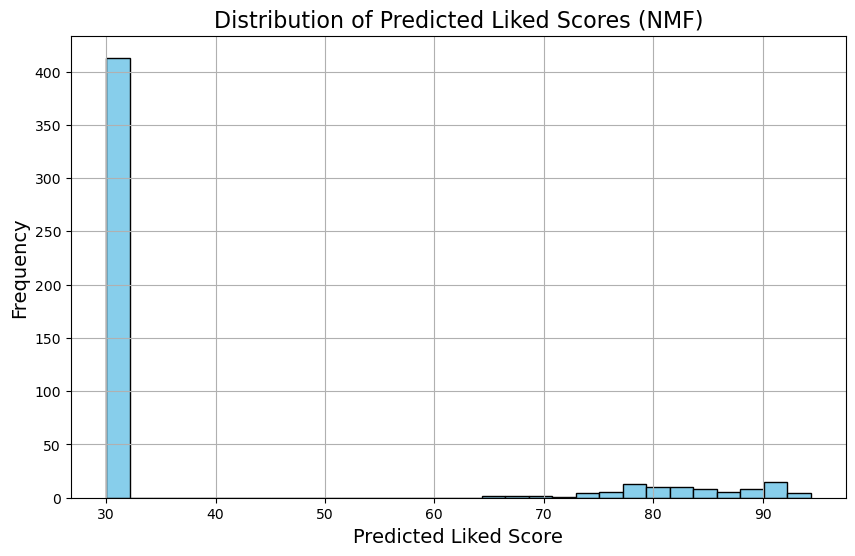

In [67]:
import matplotlib.pyplot as plt

# Visualize the distribution of predicted 'liked' scores for NMF data
plt.figure(figsize=(10, 6))
plt.hist(df_nmf_separated['Predicted_Liked_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Liked Scores (NMF)', fontsize=16)
plt.xlabel('Predicted Liked Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


## Classification Models

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))


NameError: name 'X_test' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)

print(classification_report(y_test, y_pred_gbc))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
